* Define wacky model consisting of trained encoder and geno to trait model only
* define self.inputs and self.outputs + call, should be enough

In [1]:
#!pip install git+https://github.com/google-research/bigbird.git -q

In [1]:
import os
#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # or any {‘0’, ‘1’, ‘2’}
import tensorflow as tf
#tf.keras.backend.set_floatx('float16')
# tf.compat.v1.disable_eager_execution()
# tf.compat.v1.disable_v2_behavior()
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
os.environ["TF_CPP_VMODULE"]="gpu_process_state=10,gpu_cudamallocasync_allocator=10"
# import tensorflow_probability as tfp
from tensorflow.keras import layers, Model, models, metrics, optimizers
from tensorflow import keras
from tensorflow.python.keras.backend import get_session
# import tensorflow.keras.backend as K
# import shap
# import tensorflow_datasets as tfds2
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import itertools
import gc
from typing import Any, Callable, Iterable
from itertools import chain, combinations
import os
import json
import inspect
import shutil
tf.random.set_seed(1)

2025-05-17 09:49:45.789027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747468185.972928    1550 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747468186.122019    1550 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-17 09:49:46.611372: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.18.1
Num GPUs Available:  1


## Data loading + processing

### Geno Data

In [2]:
DATA_DIR = "../../../data/"
PHENO_DIR = DATA_DIR + "pheno_data/"
child_geno_data = pd.read_csv(DATA_DIR + "all_child_genos_ordered.csv",
                               index_col=["pop", "individual"]).drop(
                                   ["p1_name", "p2_name"],
                                   axis = 1
                               )
child_pheno_data = pd.read_csv(PHENO_DIR + "pheno_oil_dist.csv",
                               index_col=["pop", "individual"])
geno_pos = pd.read_csv(DATA_DIR + "snp_cm_pos.csv", sep=";", decimal=",",
                       index_col = "SNP")
geno_pos = geno_pos.loc[list(child_geno_data.columns[:-2]),
                        ["NAM_chrom", "NAM_position"]]
geno_pos.sort_values(by=['NAM_chrom', 'NAM_position'], inplace=True)
geno_pos = geno_pos.transpose()
shared_index = child_pheno_data.index.intersection(child_geno_data.index)
child_pheno_data = child_pheno_data.reindex(shared_index)
child_geno_data = child_geno_data.reindex(shared_index).reset_index()
child_geno_data = child_geno_data.loc[:, ["pop", "individual"] + list(geno_pos.columns) +
                                       ["p1_id", "p2_id"]]
parental_geno_data = pd.read_csv( DATA_DIR + "parent_genos_ordered.csv")
parental_geno_data = parental_geno_data.loc[:, ["maize_strain"] + list(geno_pos.columns) +
                                       ["p_id"]]
parent_pheno_data = pd.read_csv(PHENO_DIR + "parents_oil.csv")
geno_chr_pos = geno_pos.loc["NAM_chrom"].to_numpy()
geno_seq_pos = geno_pos.loc["NAM_position"].to_numpy()


# Get population per sample, split populations into oop and train
pop_to_remove = [24]
pop_per_sample = child_geno_data["pop"].to_numpy()
test_pops = np.array([4, 9, 12, 14, 18, 22])# np.random.choice(np.unique(pop_per_sample), 6, replace = False)
train_eval_pops_idx = np.where(~np.isin(pop_per_sample, test_pops))[0]
eval_idx = np.random.choice(train_eval_pops_idx, 1000, replace = False)
train_idx = train_eval_pops_idx# train_eval_pops_idx[~np.isin(train_eval_pops_idx, eval_idx)]
test_idx = np.where(np.isin(pop_per_sample, test_pops))[0]
pop_per_sample_train_eval = pop_per_sample[train_eval_pops_idx]
pop_per_sample_test = np.delete(pop_per_sample, train_eval_pops_idx)

# assert ~np.any(np.isin(eval_idx, train_idx))
assert ~np.any(np.isin(eval_idx, test_idx))
assert ~np.any(np.isin(test_idx, train_idx))

In [3]:
pop_per_sample[train_idx]

array([ 1,  1,  1, ..., 26, 26, 26], shape=(2560,))

In [4]:
test_pops

array([ 4,  9, 12, 14, 18, 22])

In [5]:
all_geno_combs = list(itertools.product(["A", "T", "G", "C"], ["A", "T", "G", "C"])) + [("-", "-")]
all_geno_combs = np.unique(["".join(np.sort(cur_genos)) for cur_genos in all_geno_combs])
geno_combs_dict = {str(cur_geno[1]): cur_geno[0] for cur_geno in enumerate(all_geno_combs)}

In [6]:
def split_data(data, train_idx = train_idx, eval_idx = eval_idx, test_idx = test_idx):
    return data[train_idx, ...], data[eval_idx, ...], data[test_idx, ...]

In [7]:
def replace_with_dict(ar, dic):
    # Extract out keys and values
    k = np.array(list(dic.keys()))
    v = np.array(list(dic.values()))

    # Get argsort indices
    sidx = k.argsort()

    # Drop the magic bomb with searchsorted to get the corresponding
    # places for a in keys (using sorter since a is not necessarily sorted).
    # Then trace it back to original order with indexing into sidx
    # Finally index into values for desired output.
    out = v[sidx[np.searchsorted(k,ar,sorter=sidx)]]
    return np.asarray(out, dtype = np.float32)

In [8]:
p1_ids = child_geno_data['p1_id'].to_numpy()
p2_ids = child_geno_data['p2_id'].to_numpy()

# Parent 1 is technically always maize B73
# -> shuffle parent ids so model isnt fed same p1 input across all samples
p_genos_ids = np.stack([p1_ids, p2_ids], axis = 1)
[np.random.shuffle(cur_sub) for cur_sub in p_genos_ids]

## Extract parent phenotypes
def extract_phenos(ids, parent_data, extract_col):
    res = []
    for cur_id in ids:
        row_bools = parent_data["p_id"] == cur_id
        res.append(parent_data.loc[row_bools, extract_col].to_numpy().flatten())
    return np.array(res)

## Extract parental phenos from pandas df
p1_phenos = extract_phenos(p_genos_ids[:, 0], parent_pheno_data, ["mean_value", "sd_value"])
p2_phenos = extract_phenos(p_genos_ids[:, 1], parent_pheno_data, ["mean_value", "sd_value"])
child_pheno_np = child_pheno_data[["val_mean", "val_sd"]].to_numpy()

## Stack parental phenotypes, split to oop and train + eval
parents_phenos = np.stack([p1_phenos, p2_phenos], axis=1)
parents_phenos_np_train, parents_phenos_np_eval, parents_phenos_np_test = split_data(parents_phenos)
child_pheno_np_train, child_pheno_np_eval, child_pheno_np_test = split_data(child_pheno_np)
child_pheno_np_train = child_pheno_np_train / np.mean(parents_phenos_np_train, axis = 1)
child_pheno_np_eval = child_pheno_np_eval / np.mean(parents_phenos_np_eval, axis = 1)
child_pheno_np_test = child_pheno_np_test / np.mean(parents_phenos_np_test, axis = 1)
## Extract parental genos, split to oop and train + eval
parental_geno_red = parental_geno_data.iloc[:, 1:]
p1_genos_np = extract_phenos(p_genos_ids[:, 0], parental_geno_red, parental_geno_red.columns[:-1])
p2_genos_np = extract_phenos(p_genos_ids[:, 1], parental_geno_red, parental_geno_red.columns[:-1])
p_genos_np = np.stack([p1_genos_np, p2_genos_np], axis = 1)
p_genos_np_train, p_genos_np_eval, p_genos_np_test = split_data(p_genos_np)

# Split child geno types into train + (in population) evaluation error and OOP
# IP data == eval, OOP == test
child_geno_np_train, child_geno_np_eval, child_geno_np_test = split_data(child_geno_data.iloc[:, 2:-2].to_numpy())
child_geno_np = child_geno_data.iloc[:, 2:-2].to_numpy()

In [9]:
# p_1 = list(np.array(p_genos_np[0, 0, ...]))
# p_2  = list(np.array(p_genos_np[0, 1, ...]))
# truth = list(np.array(child_geno_np_train[0, ...]))
# bool = np.array([p_1[i] == truth[i] or p_2[i] == truth[i] or truth[i] == "--" for i in range(len(truth))])
# str_list = np.array([p_1[i] +" : "+ p_2[i] + " : " + truth[i] for i in range(len(truth))])

In [10]:
# Convert data into one hot encodings and stack to tensors

def one_hot_encode(data, vocab = all_geno_combs):
    encoded_list = [np.float16(data == cur_class) for cur_class in vocab]
    return np.stack(encoded_list, axis = -1)


# child_geno_tensor_train = one_hot_encode(child_geno_np_train)
# p_genos_tensor_train = one_hot_encode(p_genos_np_train)
#
# child_geno_tensor_eval = one_hot_encode(child_geno_np_eval)
# p_genos_tensor_eval = one_hot_encode(p_genos_np_eval)
#
# child_geno_tensor_test = one_hot_encode(child_geno_np_test)
# p_genos_tensor_test = one_hot_encode(p_genos_np_test)
#
# child_geno_tensor = one_hot_encode(child_geno_np)
# p_genos_tensor = one_hot_encode(p_genos_np)

child_geno_tensor_train = replace_with_dict(child_geno_np_train, dic = geno_combs_dict)
p_genos_tensor_train = replace_with_dict(p_genos_np_train, dic = geno_combs_dict)

child_geno_tensor_eval = replace_with_dict(child_geno_np_eval, dic = geno_combs_dict)
p_genos_tensor_eval = replace_with_dict(p_genos_np_eval, dic = geno_combs_dict)

child_geno_tensor_test = replace_with_dict(child_geno_np_test, dic = geno_combs_dict)
p_genos_tensor_test = replace_with_dict(p_genos_np_test, dic = geno_combs_dict)

child_geno_tensor = replace_with_dict(child_geno_np, dic = geno_combs_dict)
p_genos_tensor = replace_with_dict(p_genos_np, dic = geno_combs_dict)

In [11]:
# train_dataset -> actual training
# eval -> test dataset without seeing children, shared parents with train_dataset (IP)
# test_dataset -> test dataset without seeing children + parents (OOP)

geno_train_dataset = tf.data.Dataset.from_tensor_slices(
    tf.concat([p_genos_tensor_train, tf.expand_dims(child_geno_tensor_train, axis = 1)], axis = 1)
    )
meta_train_dataset = tf.data.Dataset.from_tensor_slices(
    (np.tile(geno_seq_pos, [p_genos_tensor_train.shape[0], 1]),
     np.tile(geno_chr_pos, [p_genos_tensor_train.shape[0], 1]),
     pop_per_sample[train_idx]))
pheno_train_dataset = tf.data.Dataset.from_tensor_slices((parents_phenos_np_train, child_pheno_np_train))
train_dataset = tf.data.Dataset.zip((geno_train_dataset, pheno_train_dataset,
    meta_train_dataset))
train_dataset = train_dataset.shuffle(int(1e6))
train_dataset = train_dataset.batch(32, drop_remainder=True)

geno_test_dataset = tf.data.Dataset.from_tensor_slices(
    tf.concat([p_genos_tensor_test, tf.expand_dims(child_geno_tensor_test, axis = 1)], axis = 1)
    )
meta_test_dataset = tf.data.Dataset.from_tensor_slices(
    (np.tile(geno_seq_pos, [p_genos_tensor_test.shape[0], 1]),
    np.tile(geno_chr_pos, [p_genos_tensor_test.shape[0], 1]),
    pop_per_sample[test_idx]))
pheno_test_dataset = tf.data.Dataset.from_tensor_slices((parents_phenos_np_test, child_pheno_np_test))
test_dataset = tf.data.Dataset.zip((geno_test_dataset, pheno_test_dataset,
    meta_test_dataset))
test_dataset = test_dataset.shuffle(buffer_size=int(1e6))
test_dataset = test_dataset.batch(32, drop_remainder=True)

all_samples_geno_dataset = tf.data.Dataset.from_tensor_slices(
    tf.concat([p_genos_tensor, tf.expand_dims(child_geno_tensor, axis = 1)], axis = 1)
    )
meta_all_dataset = tf.data.Dataset.from_tensor_slices(
    (np.tile(geno_seq_pos, [p_genos_tensor.shape[0], 1]),
    np.tile(geno_chr_pos, [p_genos_tensor.shape[0], 1]),
    pop_per_sample))
pheno_all_samples_dataset = tf.data.Dataset.from_tensor_slices((parents_phenos_np_train, child_pheno_np_train))
all_samples_dataset = tf.data.Dataset.zip((all_samples_geno_dataset, pheno_all_samples_dataset,
    meta_all_dataset))
all_samples_dataset = all_samples_dataset.shuffle(int(1e6))
all_samples_dataset = all_samples_dataset.batch(32, drop_remainder=True)


I0000 00:00:1747468212.131309    1550 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1747468212.222186    1550 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4699 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


In [12]:
# child_geno_np, p_genos_np, child_pheno_np, parents_phenos
full_geno_tensor = tf.concat([p_genos_tensor, tf.expand_dims(child_geno_tensor, axis = 1)], axis = 1)
parents_only_geno_tensor = p_genos_tensor
child_only_geno_tensor = tf.expand_dims(child_geno_tensor, axis = 1)
p1_only_geno_tensor = tf.expand_dims(p_genos_tensor[:, 0, ...], axis = 1)
p2_only_geno_tensor = tf.expand_dims(p_genos_tensor[:, 1, ...], axis = 1)
p1_child_geno_tensor = tf.concat([tf.expand_dims(p_genos_tensor[:, 0, ...], axis = 1),
    tf.expand_dims(child_geno_tensor, axis = 1)], axis = 1)
p2_child_geno_tensor = tf.concat([tf.expand_dims(p_genos_tensor[:, 1, ...], axis = 1),
    tf.expand_dims(child_geno_tensor, axis = 1)], axis = 1)
pheno_tupel = (parents_phenos, child_pheno_np)
test = tf.convert_to_tensor(np.random.randint(2, size =  full_geno_tensor.shape), dtype = full_geno_tensor.dtype)
# full_geno_pred = reg_vae_model.trait_call((full_geno_tensor, parents_phenos))
# parents_only_pred = reg_vae_model.trait_call((parents_only_geno_tensor, parents_phenos))
# child_only_pred = reg_vae_model.trait_call((child_only_geno_tensor, parents_phenos))
# p1_child_pred = reg_vae_model.trait_call((p1_child_geno_tensor, parents_phenos))
# p2_child_pred = reg_vae_model.trait_call((p2_child_geno_tensor, parents_phenos))
# p1_only_pred = reg_vae_model.trait_call((p1_only_geno_tensor, parents_phenos))
# p2_only_pred = reg_vae_model.trait_call((p2_only_geno_tensor, parents_phenos))
#test_pred = reg_vae_model.trait_call((test, parents_phenos), return_weights = True)

## Model definition

In [70]:
# Moved defintions to separate python scripts
# inspect_dir = "./data/reg_vae/lim_kl_scale_01_reg_w_closs_smooth/"
files_to_load = ["reg_vae_helpers.py", "cur_encoder.py", "cur_decoder.py",
    "geno_to_trait_model.py", "regression_vae.py", "bb_layers.py", "bb_attention.py"]
file_dir = "./improved_base_model_13_04/pos_enc/"
for cur_file in files_to_load:
    execfile(file_dir + cur_file)
cur_base_dir =  file_dir + "test_out/"
if not os.path.isdir(cur_base_dir):
    os.mkdir(cur_base_dir)

In [71]:
# test_batch = train_dataset.get_single_element()
for batch in train_dataset.as_numpy_iterator():
    build_batch = batch
    break
for batch in test_dataset.as_numpy_iterator():
    test_batch = batch
    break

## Individual Models

In [72]:
test_mean = tf.random.normal(shape = (1, 20, 5), mean = [0, 1, 2, 3, 10], stddev = [0, 1, 2, 3, 4])
test_stddev = tf.random.normal(shape = (1, 20, 5), mean = [1, 1, 1, 1, 1], stddev = [0, 1, 2, 3, 4])

In [73]:
reg_vae_model = reg_vae(10, 1, 1)
reg_vae_model.compile(run_eagerly = True)
# var_imp = VarImpVIANN(verbose=True)
_ = reg_vae_model((build_batch[0], build_batch[1][0], build_batch[2]))
# reg_vae_model.load_weights(file_dir + "model.weights.h5")

cur_geno.shape:  (32, 1142, 20)
cur_geno.shape:  (32, 380, 20)
cur_geno.shape:  (32, 378, 40)
cur_geno.shape:  (32, 126, 40)
cur_geno.shape:  (32, 124, 60)
cur_geno.shape:  (32, 41, 60)
cur_geno.shape:  (32, 39, 80)
cur_geno.shape:  (32, 13, 80)
cur_geno.shape:  (32, 11, 100)
cur_geno.shape:  (32, 3, 100)
cur_geno.shape:  (32, 1142, 20)
cur_geno.shape:  (32, 380, 20)
cur_geno.shape:  (32, 378, 40)
cur_geno.shape:  (32, 126, 40)
cur_geno.shape:  (32, 124, 60)
cur_geno.shape:  (32, 41, 60)
cur_geno.shape:  (32, 39, 80)
cur_geno.shape:  (32, 13, 80)
cur_geno.shape:  (32, 11, 100)
cur_geno.shape:  (32, 3, 100)
parent_genos.shape:  (32, 600)
gate2.shape:  (32, 10)
block_out.shape:  (32, 10)


/home/max/miniconda3/envs/tf-bb/lib/python3.10/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'reg_vae_15', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
I0000 00:00:1747469089.315891    2348 cuda_dnn.cc:529] Loaded cuDNN version 90300


In [74]:
res = train_and_get_results(reg_vae_model, epochs = 50,
    base_dir = cur_base_dir, files_to_backup = files_to_load,
    train_dataset = train_dataset, test_dataset = test_dataset,
    file_dir = file_dir)

geno_shape: (1144,)

Epoch 1/50
cur_geno.shape:  (32, 1142, 20)
cur_geno.shape:  (32, 380, 20)
cur_geno.shape:  (32, 378, 40)
cur_geno.shape:  (32, 126, 40)
cur_geno.shape:  (32, 124, 60)
cur_geno.shape:  (32, 41, 60)
cur_geno.shape:  (32, 39, 80)
cur_geno.shape:  (32, 13, 80)
cur_geno.shape:  (32, 11, 100)
cur_geno.shape:  (32, 3, 100)
cur_geno.shape:  (32, 1142, 20)
cur_geno.shape:  (32, 380, 20)
cur_geno.shape:  (32, 378, 40)
cur_geno.shape:  (32, 126, 40)
cur_geno.shape:  (32, 124, 60)
cur_geno.shape:  (32, 41, 60)
cur_geno.shape:  (32, 39, 80)
cur_geno.shape:  (32, 13, 80)
cur_geno.shape:  (32, 11, 100)
cur_geno.shape:  (32, 3, 100)
parent_genos.shape:  (32, 600)
gate2.shape:  (32, 10)
block_out.shape:  (32, 10)
reg_loss:  Tensor("elbo_loss_15_1/mean_absolute_percentage_error/div_no_nan:0", shape=(), dtype=float32)
rec_loss:  Tensor("elbo_loss_15_1/sparse_categorical_crossentropy/div_no_nan:0", shape=(), dtype=float32)
kl_div:  Tensor("elbo_loss_15_1/mul:0", shape=(), dtype=float3

/home/max/miniconda3/envs/tf-bb/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['reg_vae_15/dec_ini_conv0/kernel', 'reg_vae_15/dec_ini_conv0/bias', 'reg_vae_15/dec_conv_0/kernel', 'reg_vae_15/dec_conv_0/bias', 'reg_vae_15/dec_conv_1/kernel', 'reg_vae_15/dec_conv_1/bias', 'reg_vae_15/dec_conv_2/kernel', 'reg_vae_15/dec_conv_2/bias', 'reg_vae_15/dec_conv_3/kernel', 'reg_vae_15/dec_conv_3/bias', 'reg_vae_15/dec_conv_4/kernel', 'reg_vae_15/dec_conv_4/bias', 'reg_vae_15/dec_ini_embedding/embeddings', 'reg_vae_15/dec_ini_embedding/embeddings'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


cur_geno.shape:  (32, 1142, 20)
cur_geno.shape:  (32, 380, 20)
cur_geno.shape:  (32, 378, 40)
cur_geno.shape:  (32, 126, 40)
cur_geno.shape:  (32, 124, 60)
cur_geno.shape:  (32, 41, 60)
cur_geno.shape:  (32, 39, 80)
cur_geno.shape:  (32, 13, 80)
cur_geno.shape:  (32, 11, 100)
cur_geno.shape:  (32, 3, 100)
cur_geno.shape:  (32, 1142, 20)
cur_geno.shape:  (32, 380, 20)
cur_geno.shape:  (32, 378, 40)
cur_geno.shape:  (32, 126, 40)
cur_geno.shape:  (32, 124, 60)
cur_geno.shape:  (32, 41, 60)
cur_geno.shape:  (32, 39, 80)
cur_geno.shape:  (32, 13, 80)
cur_geno.shape:  (32, 11, 100)
cur_geno.shape:  (32, 3, 100)
parent_genos.shape:  (32, 600)
gate2.shape:  (32, 10)
block_out.shape:  (32, 10)
reg_loss:  Tensor("elbo_loss_15_1/mean_absolute_percentage_error/div_no_nan:0", shape=(), dtype=float32)
rec_loss:  Tensor("elbo_loss_15_1/sparse_categorical_crossentropy/div_no_nan:0", shape=(), dtype=float32)
kl_div:  Tensor("elbo_loss_15_1/mul:0", shape=(), dtype=float32)


2025-05-17 10:06:10.318159: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


cur_geno.shape:  (32, 1142, 20)
cur_geno.shape:  (32, 380, 20)
cur_geno.shape:  (32, 378, 40)
cur_geno.shape:  (32, 126, 40)
cur_geno.shape:  (32, 124, 60)
cur_geno.shape:  (32, 41, 60)
cur_geno.shape:  (32, 39, 80)
cur_geno.shape:  (32, 13, 80)
cur_geno.shape:  (32, 11, 100)
cur_geno.shape:  (32, 3, 100)
cur_geno.shape:  (32, 1142, 20)
cur_geno.shape:  (32, 380, 20)
cur_geno.shape:  (32, 378, 40)
cur_geno.shape:  (32, 126, 40)
cur_geno.shape:  (32, 124, 60)
cur_geno.shape:  (32, 41, 60)
cur_geno.shape:  (32, 39, 80)
cur_geno.shape:  (32, 13, 80)
cur_geno.shape:  (32, 11, 100)
cur_geno.shape:  (32, 3, 100)
parent_genos.shape:  (32, 600)
gate2.shape:  (32, 10)
block_out.shape:  (32, 10)
reg_loss:  Tensor("elbo_loss_15_1/mean_absolute_percentage_error/div_no_nan:0", shape=(), dtype=float32)
rec_loss:  Tensor("elbo_loss_15_1/sparse_categorical_crossentropy/div_no_nan:0", shape=(), dtype=float32)
kl_div:  Tensor("elbo_loss_15_1/mul:0", shape=(), dtype=float32)


2025-05-17 10:06:24.431429: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1 train metrics:
kl_loss: 3.0050039291381836, kl_scale: 0.009999994188547134, elbo_rec: 1.058059573173523, elbo_reg: 137.8788299560547, reg_loss: 137.8788299560547, epoch: 0.0, cat_acc: 0.6193576455116272, reconstruction_loss: 1.058059573173523, mean_deviation: 105.18221282958984, sd_deviation: 170.57540893554688, 0_acc: 0.01624101959168911, 1_acc: 0.6817677021026611, 2_acc: 0.0010147133143618703, 3_acc: 0.0058316560462117195, 4_acc: 0.008421558886766434, 5_acc: 0.6510341167449951, 6_acc: 0.0008988187182694674, 7_acc: 0.005159112624824047, 8_acc: 0.6343891024589539, 9_acc: 0.003697834210470319, 10_acc: 0.6641415953636169, 
Epoch 1 val metrics:
kl_loss: 6.350526809692383, kl_scale: 1.0, elbo_rec: 7.084417819976807, elbo_reg: 84.32455444335938, reg_loss: 77.97402954101562, epoch: 0.0, cat_acc: 0.6307398676872253, reconstruction_loss: 0.7338907718658447, mean_deviation: 65.82429504394531, sd_deviation: 90.12374877929688, 0_acc: 0.0005425679846666753, 1_acc: 0.7240316867828369, 2_acc

2025-05-17 10:07:26.278586: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2 train metrics:
kl_loss: 10.535600662231445, kl_scale: 0.009999994188547134, elbo_rec: 0.7058506608009338, elbo_reg: 102.85652160644531, reg_loss: 102.85652160644531, epoch: 1.0, cat_acc: 0.6380199193954468, reconstruction_loss: 0.7058506608009338, mean_deviation: 71.94625091552734, sd_deviation: 133.7667999267578, 0_acc: 0.0021228273399174213, 1_acc: 0.7095910906791687, 2_acc: 0.0001691188954282552, 3_acc: 0.00010321514855604619, 4_acc: 0.004571703728288412, 5_acc: 0.6678847670555115, 6_acc: 0.0, 7_acc: 4.8216006689472124e-05, 8_acc: 0.6512131690979004, 9_acc: 0.0, 10_acc: 0.6854374408721924, 
Epoch 2 val metrics:
kl_loss: 11.796052932739258, kl_scale: 1.0, elbo_rec: 12.49885368347168, elbo_reg: 70.48939514160156, reg_loss: 58.693336486816406, epoch: 1.0, cat_acc: 0.6345722079277039, reconstruction_loss: 0.7028018236160278, mean_deviation: 45.80122375488281, sd_deviation: 71.58545684814453, 0_acc: 0.00030666886596009135, 1_acc: 0.6927914023399353, 2_acc: 0.0, 3_acc: 0.0, 4_acc:

2025-05-17 10:09:20.929327: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4 train metrics:
kl_loss: 27.439687728881836, kl_scale: 0.009999994188547134, elbo_rec: 0.6809834241867065, elbo_reg: 67.94230651855469, reg_loss: 67.94230651855469, epoch: 3.0, cat_acc: 0.6426772475242615, reconstruction_loss: 0.6809834241867065, mean_deviation: 42.4001579284668, sd_deviation: 93.48444366455078, 0_acc: 0.0067392815835773945, 1_acc: 0.7038151621818542, 2_acc: 0.0, 3_acc: 5.1607574278023094e-05, 4_acc: 0.0064966315403580666, 5_acc: 0.68060302734375, 6_acc: 0.0, 7_acc: 0.00024108003708533943, 8_acc: 0.6574846506118774, 9_acc: 0.0, 10_acc: 0.6897752285003662, 
Epoch 4 val metrics:
kl_loss: 32.2376708984375, kl_scale: 1.0, elbo_rec: 32.925601959228516, elbo_reg: 73.60234832763672, reg_loss: 41.364681243896484, epoch: 3.0, cat_acc: 0.6377479434013367, reconstruction_loss: 0.6879273056983948, mean_deviation: 27.75609016418457, sd_deviation: 54.97328186035156, 0_acc: 0.007191351614892483, 1_acc: 0.7074969410896301, 2_acc: 0.0, 3_acc: 0.0, 4_acc: 0.0, 5_acc: 0.6684157252

2025-05-17 10:13:21.697398: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8 train metrics:
kl_loss: 94.3071517944336, kl_scale: 0.009999994188547134, elbo_rec: 0.6717966794967651, elbo_reg: 34.811214447021484, reg_loss: 34.811214447021484, epoch: 7.0, cat_acc: 0.645764172077179, reconstruction_loss: 0.6717966794967651, mean_deviation: 20.7023983001709, sd_deviation: 48.92005157470703, 0_acc: 0.014479721896350384, 1_acc: 0.7076523303985596, 2_acc: 0.001691188896074891, 3_acc: 0.0, 4_acc: 0.02382098138332367, 5_acc: 0.6799519062042236, 6_acc: 0.0, 7_acc: 0.0037608486600220203, 8_acc: 0.6633382439613342, 9_acc: 0.0, 10_acc: 0.6928032040596008, 
Epoch 8 val metrics:
kl_loss: 109.56903839111328, kl_scale: 1.0, elbo_rec: 110.25065612792969, elbo_reg: 137.65792846679688, reg_loss: 28.088895797729492, epoch: 7.0, cat_acc: 0.6387718319892883, reconstruction_loss: 0.6816173195838928, mean_deviation: 14.360285758972168, sd_deviation: 41.817508697509766, 0_acc: 0.010829302482306957, 1_acc: 0.6802965402603149, 2_acc: 0.0, 3_acc: 0.0, 4_acc: 0.0, 5_acc: 0.6774607300

2025-05-17 10:21:32.889554: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16 train metrics:
kl_loss: 76.24332427978516, kl_scale: 0.009999994188547134, elbo_rec: 0.6688306331634521, elbo_reg: 26.768936157226562, reg_loss: 26.768936157226562, epoch: 15.0, cat_acc: 0.6471735239028931, reconstruction_loss: 0.6688306331634521, mean_deviation: 13.660504341125488, sd_deviation: 39.87736129760742, 0_acc: 0.013385863043367863, 1_acc: 0.7142595648765564, 2_acc: 0.0015220700297504663, 3_acc: 0.0, 4_acc: 0.01612127013504505, 5_acc: 0.6757521033287048, 6_acc: 0.0, 7_acc: 0.0038090646266937256, 8_acc: 0.664434015750885, 9_acc: 0.00017608734196983278, 10_acc: 0.6964959502220154, 
Epoch 16 val metrics:
kl_loss: 66.43871307373047, kl_scale: 1.0, elbo_rec: 67.11868286132812, elbo_reg: 91.54835510253906, reg_loss: 25.109630584716797, epoch: 15.0, cat_acc: 0.6383559703826904, reconstruction_loss: 0.6799675822257996, mean_deviation: 11.479853630065918, sd_deviation: 38.73941421508789, 0_acc: 0.009242231026291847, 1_acc: 0.7155589461326599, 2_acc: 0.0, 3_acc: 0.0, 4_acc: 0

KeyboardInterrupt: 

In [ ]:
# reg_vae_model.save_weights("test_model.weights.h5")
reg_vae_model.load_weights("test_model.weights.h5")

/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 162 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 198 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
#sum(np.array(build_batch[0][0, 2, ...]) == 0)
sum(np.array(build_batch[0][0, 2, ...]) == np.argmax(train_out[1], axis = -1)[0, ...])

np.int64(646)

In [20]:
test_out = reg_vae_model.call((test_batch[0], test_batch[1][0], build_batch[2]), return_activations = False)

In [25]:
test_batch[0]

array([[[ 5.,  1., 10., ..., 10., 10.,  5.],
        [ 8., 10.,  5., ...,  5.,  5.,  5.],
        [ 5.,  1., 10., ...,  0.,  7.,  5.]],

       [[ 8., 10.,  5., ...,  5.,  5.,  5.],
        [ 5.,  1., 10., ..., 10., 10.,  5.],
        [ 8., 10.,  5., ..., 10., 10.,  5.]],

       [[ 5.,  1., 10., ..., 10., 10.,  5.],
        [ 5., 10., 10., ...,  5.,  5.,  8.],
        [ 5.,  1., 10., ..., 10., 10.,  5.]],

       ...,

       [[ 5., 10.,  5., ...,  5.,  5.,  6.],
        [ 5.,  1., 10., ..., 10., 10.,  5.],
        [ 5.,  4., 10., ...,  0.,  5.,  8.]],

       [[ 5., 10.,  5., ...,  5.,  5.,  6.],
        [ 5.,  1., 10., ..., 10., 10.,  5.],
        [ 5.,  1., 10., ...,  5.,  5.,  8.]],

       [[ 5., 10.,  5., ...,  5.,  5.,  6.],
        [ 5.,  1., 10., ..., 10., 10.,  5.],
        [ 5., 10., 10., ...,  5.,  5.,  5.]]],
      shape=(32, 3, 1144), dtype=float32)

In [27]:
tf.argmax(test_out[1])

<tf.Tensor: shape=(1144, 11), dtype=int64, numpy=
array([[ 0, 18, 15, ..., 17,  5,  4],
       [12, 26, 11, ...,  4, 22, 15],
       [31, 15, 22, ..., 10, 26,  3],
       ...,
       [25, 25,  5, ...,  5,  8,  8],
       [25, 25, 21, ...,  2, 27,  8],
       [21, 18,  4, ...,  2,  4, 21]], shape=(1144, 11))>

In [ ]:
rand_geno = tf.convert_to_tensor(np.random.randint(2, size = build_batch[0].shape), dtype = full_geno_tensor.dtype)
rand_out = reg_vae_model.call((rand_geno, test_batch[1][0], build_batch[2]), return_activations = False)
train_out = reg_vae_model.call((build_batch[0], build_batch[1][0], build_batch[2]), return_activations = False)
test_out = reg_vae_model.call((test_batch[0], test_batch[1][0], build_batch[2]), return_activations = False)
print(np.mean(abs(train_out[2] - build_batch[1][1])/build_batch[1][1], axis = 0) * 100)
print(np.mean(abs(test_out[2] - test_batch[1][1])/test_batch[1][1], axis = 0) * 100)
print(np.mean(abs(rand_out[2] - test_batch[1][1])/test_batch[1][1], axis = 0) * 100)

[ 8.681193 33.667965]
[10.146034 34.595604]
[15.06311  52.229298]


In [ ]:
res_per_pop = {}
for cur_pop in np.unique(pop_per_sample):
    pop_geno_tensor = np.array(full_geno_tensor)[pop_per_sample == cur_pop, ...]
    # pheno_tupel = (parents_phenos, child_pheno_np)
    pheno_pop_tupel = (np.array(parents_phenos)[pop_per_sample == cur_pop, ...],
                       child_pheno_np[pop_per_sample == cur_pop, ...])
    pop_out = reg_vae_model.call((pop_geno_tensor, pheno_pop_tupel[0]), return_activations = True)
    res_per_pop[str(cur_pop)] = pop_out

In [ ]:
reg_gate_per_pop = []
for cur_pop in np.unique(pop_per_sample):
    cur_df = pd.DataFrame(res_per_pop[str(cur_pop)][-2])
    cur_df["pop"] = cur_pop
    pop_label = "test" if cur_pop in test_pops else "train"
    cur_df["dtype"] = pop_label
    reg_gate_per_pop.append(cur_df)

In [ ]:
rand_out_df = pd.DataFrame(rand_out[-2])
rand_out_df["pop"] = "random"
rand_out_df["dtype"] = "random"

In [ ]:
pd.concat(reg_gate_per_pop + [rand_out_df]).to_csv("reg_gate_per_pop.csv")

In [30]:
pred_off_list = []
p1_in_list = []
p2_in_list = []
for cur_test_batch in test_dataset:
    b_size = cur_test_batch[0].shape[0]
    cur_test_out = reg_vae_model.call((cur_test_batch[0], cur_test_batch[1][0],
                                       cur_test_batch[2]), return_activations = False)
    test_token_pred = np.array(tf.math.argmax(cur_test_out[1], axis = -1))
    test_parents_in = tf.split(test_batch[0][:, 0:2], 2, 1)
    test_parents_in_1 = pd.DataFrame(np.squeeze(test_parents_in[0]))
    test_parents_in_1["dtype"] = "parent_1"
    test_parents_in_1["pop"] = cur_test_batch[2][2]
    test_parents_in_2 = pd.DataFrame(np.squeeze(test_parents_in[1]))
    test_parents_in_2["dtype"] = "parent_1"
    test_parents_in_2["pop"] = cur_test_batch[2][2]
    p1_in_list.append(test_parents_in_1)
    p2_in_list.append(test_parents_in_2)

    test_token_pred = pd.DataFrame(test_token_pred)
    test_token_pred["dtype"] = "offspring"
    test_token_pred["pop"] = cur_test_batch[2][2]
    pred_off_list.append(test_token_pred)
    # train_token_pred = tf.math.argmax(train_out[-1], axis = -1)
    # train_parents_in = build_batch[0][:, 0:2]

2025-04-16 13:00:34.778868: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [32]:
p1_df = pd.concat(p1_in_list)
p1_df["sample_id"] = np.arange(p1_df.shape[0])
p1_df.to_csv(cur_base_dir + "p1_test_genos.csv", index = False)
p2_df = pd.concat(p2_in_list)
p2_df["sample_id"] = np.arange(p2_df.shape[0])
p2_df.to_csv(cur_base_dir + "p2_test_genos.csv", index = False)
pred_off_df = pd.concat(pred_off_list)
pred_off_df["sample_id"] = np.arange(pred_off_df.shape[0])
pred_off_df.to_csv(cur_base_dir + "pred_off_test.csv", index = False)

# Positional encoding attention

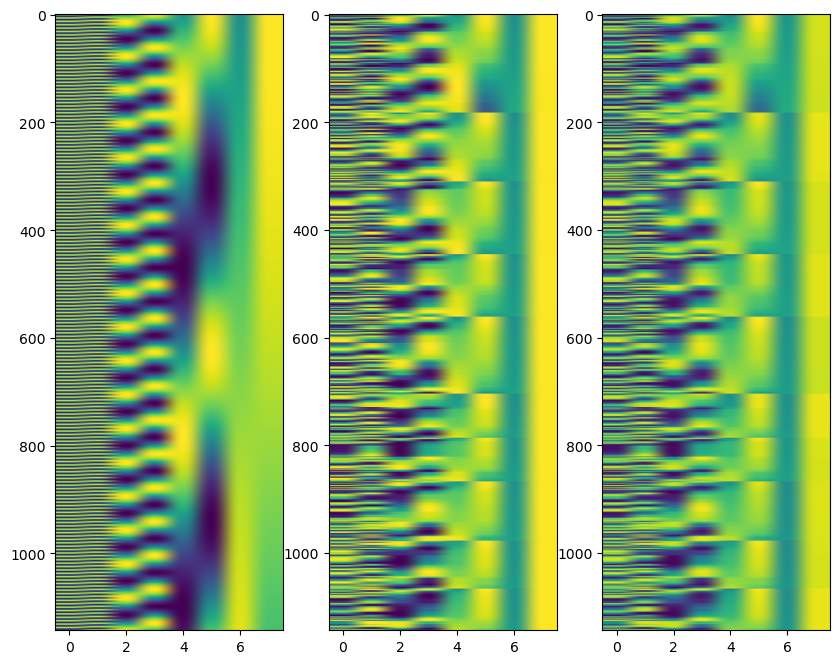

In [184]:
chr_enc = reg_vae_model.encoder.chr_embedding.call(test_batch[2][1][1, :])
chr_dot = tf.matmul(
    tf.squeeze(chr_enc),
    tf.transpose(tf.squeeze(chr_enc)))
snp_positions = test_batch[2][0][0, :]
seq_positions = np.arange(1, 1144)
denom = 10000.0
snp_enc = new_positional_encoding(snp_positions, 8, denominator = denom)
snp_dot =tf.matmul(
    tf.squeeze(snp_enc),
    tf.transpose(tf.squeeze(snp_enc)))
snp_enc_chr = new_positional_encoding(snp_positions, 8, denominator = denom) + chr_enc
snp_dot_chr =tf.matmul(
    tf.squeeze(snp_enc_chr),
    tf.transpose(tf.squeeze(snp_enc_chr)))
seq_enc = new_positional_encoding(seq_positions, 8, denominator = denom)
seq_dot =tf.matmul(
    tf.squeeze(seq_enc),
    tf.transpose(tf.squeeze(seq_enc)))
plt.rcParams['figure.figsize'] = [10, 8]
fig, ax = plt.subplots(1, 3)
im = ax[0].imshow(seq_enc[0, ...], aspect = "auto")
im = ax[1].imshow(snp_enc[0, ...], aspect = "auto")
im = ax[2].imshow(snp_enc_chr[0, ...], aspect = "auto")

In [193]:
np.max(tf.nn.softmax(snp_dot_chr))

np.float32(0.00750939)

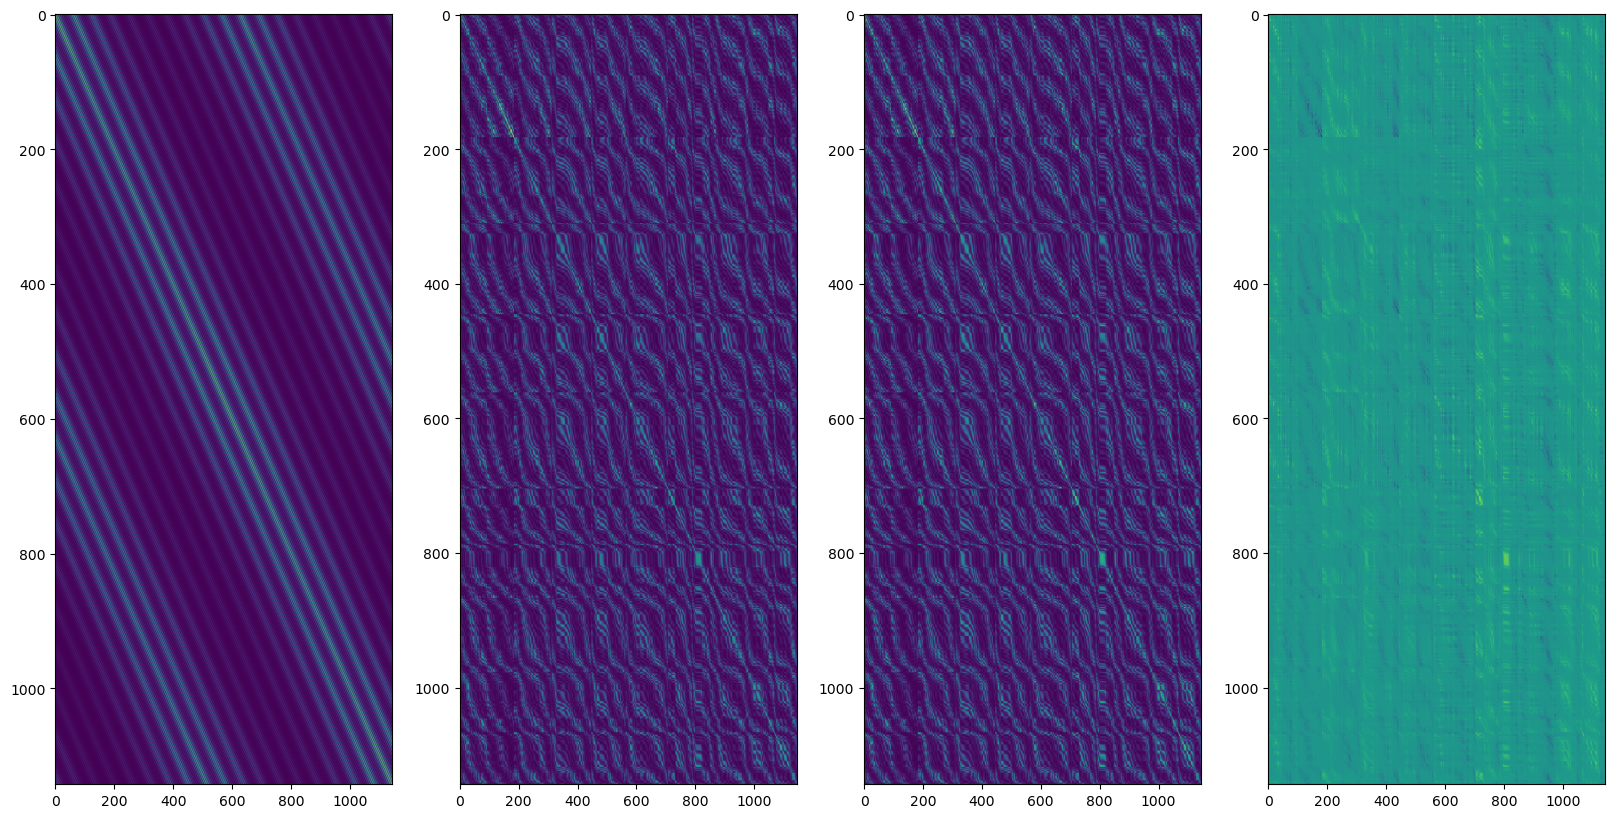

In [187]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots(1, 4)
im = ax[0].imshow(tf.nn.softmax(seq_dot), aspect = "auto")
im = ax[1].imshow(tf.nn.softmax(snp_dot), aspect = "auto")
im = ax[2].imshow(tf.nn.softmax(snp_dot_chr), aspect = "auto")
im = ax[3].imshow(tf.nn.softmax(snp_dot_chr)- tf.nn.softmax(snp_dot), aspect = "auto")

# Test layers

In [ ]:
positional_encoding(10, 3)

<tf.Tensor: shape=(1, 10, 3), dtype=float32, numpy=
array([[[ 0.        ,  1.        ,  0.        ],
        [ 0.84147096,  0.5403023 ,  0.00215443],
        [ 0.9092974 , -0.41614684,  0.00430886],
        [ 0.14112   , -0.9899925 ,  0.00646326],
        [-0.7568025 , -0.6536436 ,  0.00861763],
        [-0.9589243 ,  0.2836622 ,  0.01077196],
        [-0.2794155 ,  0.96017027,  0.01292625],
        [ 0.6569866 ,  0.75390226,  0.01508047],
        [ 0.98935825, -0.14550003,  0.01723462],
        [ 0.4121185 , -0.91113025,  0.0193887 ]]], dtype=float32)>

In [ ]:
def positional_encoding(position, d_model):

    # Create a matrix of shape [position, d_model] where each element is the position index
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))

    # Apply sine to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # Apply cosine to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

# Example use
position = 50  # Length of the sequence
d_model = 512  # Dimensionality of the model's output
pos_encoding = positional_encoding(position, d_model)

print(pos_encoding.shape)  # Output the shape to verify the dimensions


(1, 50, 512)


In [ ]:
p_embed = layers.Embedding(11, 20)(build_batch[0])

In [ ]:
test_bb_att = MultiHeadedAttentionLayer(attention_type = 'block_sparse',
                                num_attention_heads = 10,
                                name = "test",
                                size_per_head = 2,
                                from_seq_length = 1144,
                                to_seq_length = 1144,
                                from_block_size = 88,
                                to_block_size = 88)

In [ ]:
b_size = p_embed.shape[0]
seq_len = p_embed.shape[2]
block_size = 88
att_mask = tf.ones([b_size, seq_len, seq_len])
band_mask = tf.ones([b_size, 1,seq_len//block_size-4, block_size, 3*block_size])
from_mask = tf.ones([b_size, 1, seq_len, 1])
to_mask = tf.ones([b_size, 1, 1, seq_len])
from_blocked_mask = tf.ones([b_size,seq_len//block_size, block_size])
to_blocked_mask = tf.ones([b_size,seq_len//block_size, block_size])


In [ ]:
none_mask =tf.ones(shape = p_embed.shape)
test_bb_att(from_tensor = tf.squeeze(tf.split(p_embed, p_embed.shape[1], axis = 1)[0]),
            to_tensor = tf.squeeze(tf.split(p_embed, p_embed.shape[1], axis = 1)[1]),
            masks = [att_mask, band_mask, from_mask, to_mask, from_blocked_mask, to_blocked_mask])

<tf.Tensor: shape=(16, 1144, 10, 2), dtype=float32, numpy=
array([[[[-3.19393259e-03,  7.27537379e-04],
         [-2.32667280e-05,  2.27037189e-03],
         [ 2.49837432e-03, -2.91267788e-04],
         ...,
         [-8.29603407e-04,  9.03831911e-04],
         [ 9.18395599e-05,  1.35777562e-04],
         [ 1.34361116e-03,  7.01114128e-04]],

        [[-3.19393259e-03,  7.27537379e-04],
         [-2.32665261e-05,  2.27037189e-03],
         [ 2.49839784e-03, -2.91260891e-04],
         ...,
         [-8.29594734e-04,  9.03832552e-04],
         [ 9.18366350e-05,  1.35777867e-04],
         [ 1.34361174e-03,  7.01110752e-04]],

        [[-3.19393026e-03,  7.27537263e-04],
         [-2.32698494e-05,  2.27035629e-03],
         [ 2.49841530e-03, -2.91259872e-04],
         ...,
         [-8.29609053e-04,  9.03845415e-04],
         [ 9.18413498e-05,  1.35774826e-04],
         [ 1.34361221e-03,  7.01109995e-04]],

        ...,

        [[-3.19393515e-03,  7.27536390e-04],
         [-2.32696329e-0

# Test if gradients flow from trait to encoder model

In [ ]:
cur_pop = 1
pop_geno_tensor = np.array(full_geno_tensor)[pop_per_sample == cur_pop, ...]
# pheno_tupel = (parents_phenos, child_pheno_np)
pheno_pop_tupel = (np.array(parents_phenos)[pop_per_sample == cur_pop, ...],
                   child_pheno_np[pop_per_sample == cur_pop, ...])

In [ ]:
# build_batch[0], build_batch[1][0]
test_geno = pop_geno_tensor
kl_scale = 0.1
fake_epoch = 10
test_p_geno = test_geno[:, :2, ...]
test_c_geno = test_geno[:, 2, ...]
with tf.GradientTape(persistent = True) as grad_tape:
    mean, logvar, enc_act = reg_vae_model.encoder.call(test_geno, training = True,
        return_activations = False)
    embed_x = reg_vae_model.sample_z(mean, logvar)
    geno_logits, dec_act, dec_gate, _ = reg_vae_model.decoder.call(test_p_geno, embed_x, training = True,
        return_activations = False)
    pheno_pred, reg_act, reg_gate = reg_vae_model.regressor.call(pheno_pop_tupel[0], embed_x, test_p_geno, training = True,
        return_activations = False)
    kl_loss, reg_loss, rec_loss  = reg_vae_model.loss_fn(test_c_geno, geno_logits, mean, logvar,
        trait_pred = pheno_pred, trait_true = pheno_pop_tupel[1], epoch = fake_epoch)
    elbo_rec_loss = rec_loss * 10000
    elbo_reg_loss = reg_loss
    total_loss = kl_loss * kl_scale + reg_loss + rec_loss

dec_grads = grad_tape.gradient(elbo_rec_loss, reg_vae_model.decoder.trainable_variables)
reg_grads = grad_tape.gradient(elbo_reg_loss, reg_vae_model.regressor.trainable_variables)
enc_grads = grad_tape.gradient(total_loss, reg_vae_model.encoder.trainable_variables)

geno_pred.shape:  (162, 1144, 11)
block_out.shape:  (162, 100)
reg_loss:  188.76756
rec_loss:  74798.81
kl_div:  [1.8924475e-06 1.9228457e-06 1.9723177e-06 1.9401311e-06 1.9374490e-06
 1.8924475e-06 1.8885731e-06 1.9210577e-06 1.9690394e-06 1.9061565e-06
 1.9022823e-06 1.8239022e-06 1.8215179e-06 1.8694997e-06 1.9174813e-06
 1.8694997e-06 1.9338727e-06 1.8528103e-06 1.8548966e-06 1.8942357e-06
 1.7756224e-06 1.8659234e-06 1.8969179e-06 1.9288063e-06 1.8826127e-06
 1.8435717e-06 1.7932057e-06 1.9249319e-06 1.9028782e-06 1.9145011e-06
 1.8441677e-06 1.9067526e-06 1.8894673e-06 1.9150973e-06 1.9174813e-06
 1.8683075e-06 1.8671155e-06 1.9213558e-06 1.8426776e-06 1.8745661e-06
 1.9180775e-06 1.9136071e-06 1.9764900e-06 1.9448996e-06 1.9928814e-06
 1.8849969e-06 1.9314884e-06 1.9070507e-06 1.9517540e-06 1.9681454e-06
 1.8811226e-06 1.8852949e-06 1.8307567e-06 1.8894673e-06 1.9341708e-06
 1.9222498e-06 2.0116568e-06 2.0185114e-06 1.9437075e-06 1.9451975e-06
 1.9410252e-06 1.9794702e-06 1.8417

In [ ]:
reg_layer_names = [cur_layer.path for cur_layer in
    reg_vae_model.regressor.trainable_variables]
dec_layer_names = [cur_layer.path for cur_layer in
    reg_vae_model.decoder.trainable_variables]
enc_layer_names = [cur_layer.path for cur_layer in
    reg_vae_model.encoder.trainable_variables]

In [ ]:
dec_grad_mean = {dec_layer_names[cur_idx] : tf.reduce_mean(abs(dec_grads[cur_idx])).numpy() for cur_idx in range(len(dec_grads))}
dec_grad_var = {dec_layer_names[cur_idx] : tf.math.reduce_variance(dec_grads[cur_idx]).numpy() for cur_idx in range(len(dec_grads))}
reg_grad_mean = {reg_layer_names[cur_idx] : tf.reduce_mean(abs(reg_grads[cur_idx])).numpy() for cur_idx in range(len(reg_grads))}
reg_grad_var = {reg_layer_names[cur_idx] : tf.math.reduce_variance(reg_grads[cur_idx]).numpy() for cur_idx in range(len(reg_grads))}
enc_grad_mean = {enc_layer_names[cur_idx] : tf.reduce_mean(abs(enc_grads[cur_idx])).numpy() for cur_idx in range(len(enc_grads))}
enc_grad_var = {enc_layer_names[cur_idx] : tf.math.reduce_variance(enc_grads[cur_idx]).numpy() for cur_idx in range(len(enc_grads))}

In [ ]:
enc_grad_mean #kl only

{'reg_vae_1/encoder_1/ini_geno_layer/kernel': np.float32(8.417283e-06),
 'reg_vae_1/encoder_1/ini_geno_layer/bias': np.float32(7.8656856e-05),
 'reg_vae_1/encoder_1/encoder_dense_d_1_w_0/kernel': np.float32(3.6658428e-05),
 'reg_vae_1/encoder_1/encoder_dense_d_1_w_0/bias': np.float32(0.000119183955),
 'reg_vae_1/encoder_1/encoder_dense_d_2_w_0/kernel': np.float32(7.635411e-05),
 'reg_vae_1/encoder_1/encoder_dense_d_2_w_0/bias': np.float32(0.00021909647),
 'reg_vae_1/encoder_1/encoder_dense_d_3_w_0/kernel': np.float32(8.433294e-05),
 'reg_vae_1/encoder_1/encoder_dense_d_3_w_0/bias': np.float32(0.00036539475),
 'reg_vae_1/encoder_1/encoder_dense_d_4_w_0/kernel': np.float32(0.000100817844),
 'reg_vae_1/encoder_1/encoder_dense_d_4_w_0/bias': np.float32(0.00068527745),
 'reg_vae_1/encoder_1/encoder_dense_d_5_w_0/kernel': np.float32(0.00013681459),
 'reg_vae_1/encoder_1/encoder_dense_d_5_w_0/bias': np.float32(0.0012198447),
 'reg_vae_1/encoder_1/encoder_dense_d_6_w_0/kernel': np.float32(0.00

In [ ]:
enc_grad_var #kl only

{'reg_vae_1/encoder_1/ini_geno_layer/kernel': np.float32(7.858511e-10),
 'reg_vae_1/encoder_1/ini_geno_layer/bias': np.float32(1.0758261e-08),
 'reg_vae_1/encoder_1/encoder_dense_d_1_w_0/kernel': np.float32(3.291953e-09),
 'reg_vae_1/encoder_1/encoder_dense_d_1_w_0/bias': np.float32(2.2720434e-08),
 'reg_vae_1/encoder_1/encoder_dense_d_2_w_0/kernel': np.float32(1.665927e-08),
 'reg_vae_1/encoder_1/encoder_dense_d_2_w_0/bias': np.float32(8.163451e-08),
 'reg_vae_1/encoder_1/encoder_dense_d_3_w_0/kernel': np.float32(1.9323107e-08),
 'reg_vae_1/encoder_1/encoder_dense_d_3_w_0/bias': np.float32(2.3211682e-07),
 'reg_vae_1/encoder_1/encoder_dense_d_4_w_0/kernel': np.float32(2.8069838e-08),
 'reg_vae_1/encoder_1/encoder_dense_d_4_w_0/bias': np.float32(7.2393095e-07),
 'reg_vae_1/encoder_1/encoder_dense_d_5_w_0/kernel': np.float32(5.0194014e-08),
 'reg_vae_1/encoder_1/encoder_dense_d_5_w_0/bias': np.float32(2.3598948e-06),
 'reg_vae_1/encoder_1/encoder_dense_d_6_w_0/kernel': np.float32(6.2892

In [ ]:
enc_grad_var # full loss

{'reg_vae_1/encoder_1/ini_geno_layer/kernel': np.float32(0.009065907),
 'reg_vae_1/encoder_1/ini_geno_layer/bias': np.float32(0.10015806),
 'reg_vae_1/encoder_1/encoder_dense_d_1_w_0/kernel': np.float32(0.031776477),
 'reg_vae_1/encoder_1/encoder_dense_d_1_w_0/bias': np.float32(0.204509),
 'reg_vae_1/encoder_1/encoder_dense_d_2_w_0/kernel': np.float32(0.124681234),
 'reg_vae_1/encoder_1/encoder_dense_d_2_w_0/bias': np.float32(0.60937434),
 'reg_vae_1/encoder_1/encoder_dense_d_3_w_0/kernel': np.float32(0.1682483),
 'reg_vae_1/encoder_1/encoder_dense_d_3_w_0/bias': np.float32(2.0105593),
 'reg_vae_1/encoder_1/encoder_dense_d_4_w_0/kernel': np.float32(0.27551708),
 'reg_vae_1/encoder_1/encoder_dense_d_4_w_0/bias': np.float32(7.0218687),
 'reg_vae_1/encoder_1/encoder_dense_d_5_w_0/kernel': np.float32(0.5671158),
 'reg_vae_1/encoder_1/encoder_dense_d_5_w_0/bias': np.float32(26.650568),
 'reg_vae_1/encoder_1/encoder_dense_d_6_w_0/kernel': np.float32(0.76619554),
 'reg_vae_1/encoder_1/encoder

In [ ]:
enc_grad_mean

{'reg_vae_1/encoder_1/ini_geno_layer/kernel': np.float32(0.028831791),
 'reg_vae_1/encoder_1/ini_geno_layer/bias': np.float32(0.24276355),
 'reg_vae_1/encoder_1/encoder_dense_d_1_w_0/kernel': np.float32(0.111143515),
 'reg_vae_1/encoder_1/encoder_dense_d_1_w_0/bias': np.float32(0.34969547),
 'reg_vae_1/encoder_1/encoder_dense_d_2_w_0/kernel': np.float32(0.21157932),
 'reg_vae_1/encoder_1/encoder_dense_d_2_w_0/bias': np.float32(0.60428905),
 'reg_vae_1/encoder_1/encoder_dense_d_3_w_0/kernel': np.float32(0.24233125),
 'reg_vae_1/encoder_1/encoder_dense_d_3_w_0/bias': np.float32(1.0520618),
 'reg_vae_1/encoder_1/encoder_dense_d_4_w_0/kernel': np.float32(0.29802853),
 'reg_vae_1/encoder_1/encoder_dense_d_4_w_0/bias': np.float32(2.0287967),
 'reg_vae_1/encoder_1/encoder_dense_d_5_w_0/kernel': np.float32(0.44954595),
 'reg_vae_1/encoder_1/encoder_dense_d_5_w_0/bias': np.float32(4.0129476),
 'reg_vae_1/encoder_1/encoder_dense_d_6_w_0/kernel': np.float32(0.5298442),
 'reg_vae_1/encoder_1/encod

# Shap values

In [ ]:
exec(open("shap_vae.py").read())

In [ ]:
shap_geno_train_dataset = np.concatenate(
        [p_genos_tensor_train, tf.expand_dims(child_geno_tensor_train, axis = 1)],
        axis = 1
    )
background_idx = np.random.choice(shap_geno_train_dataset.shape[0], 1000, replace=False)
shap_background = [shap_geno_train_dataset,
    parents_phenos_np_train]

shap_geno_test_dataset = np.concatenate(
        [p_genos_tensor_test, tf.expand_dims(child_geno_tensor_test, axis = 1)],
        axis = 1
    )
test_idx = np.random.choice(shap_geno_test_dataset.shape[0], 400, replace=False)
shap_test = [shap_geno_test_dataset[test_idx, ...],
    parents_phenos_np_test[test_idx, ...]]

In [ ]:
shap_model = latent_reg(100, 5)
_ = shap_model(shap_background)
shap_model.load_weights("/home/max/Projects/Master/reg_vae/res_per_trait/silk/run1/model.weights.h5", skip_mismatch=True, by_name=True)
shap_model.inputs = tf.zeros(shap_background[0].shape)
shap_model.outputs = [tf.zeros(_.shape)]

encoder_dense_d_1_w_0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

geno_x: Tensor("data:0", shape=(2615, 3, 1144, 11), dtype=float32)
parent_traits: Tensor("data_1:0", shape=(2615, 2, 2), dtype=float32)
scaling_weights.shape: (2615, 2, 2)
parent_phenos.shape: (2615, 2, 2)
scaling_weights.shape: (2615, 2, 2)
parent_phenos.shape: (2615, 2, 2)


2025-02-05 11:40:00.318401: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-02-05 11:40:01.023485: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-02-05 11:40:02.719870: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2025-02-05 11:40:02.792173: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [ ]:
# e = shap.DeepExplainer((shap_model.layers[0].input, shap_model.layers[-1].output), background)
e = shap.GradientExplainer(shap_model, shap_background, multi_input_focus = 0)

In [ ]:
shap_values = e.shap_values(shap_test, shap_feature = 1, nsamples = 400)

sample_scale_mask_shape:  [1, 1144, 1]
geno_x: Tensor("data:0", shape=(400, 3, 1144, 11), dtype=float32)
parent_traits: Tensor("data_1:0", shape=(400, 2, 2), dtype=float32)
scaling_weights.shape: (400, 2, 2)
parent_phenos.shape: (400, 2, 2)
model_output_ranks.shape:  (400, 2)
geno_x: Tensor("data:0", shape=(50, 3, 1144, 11), dtype=float32)
parent_traits: Tensor("data_1:0", shape=(50, 2, 2), dtype=float32)
scaling_weights.shape: (50, 2, 2)
parent_phenos.shape: (50, 2, 2)


In [ ]:
shap_per_feature = [tf.einsum("ABCD -> BCD", cur_shap) for cur_shap in shap_values]

In [ ]:
shap_per_feature[0].shape

TensorShape([3, 1144, 11])

In [ ]:
shap_per_input_geno = [tf.reduce_mean(cur_shap, axis = [-1, -2]) for cur_shap in shap_per_feature]
shap_per_geno = [tf.reduce_mean(cur_shap, axis = [0, 1]) for cur_shap in shap_per_feature]
shap_per_allele = [tf.reduce_mean(cur_shap, axis = [0, -1]) for cur_shap in shap_per_feature]

In [ ]:
pd.DataFrame(shap_per_allele[0]).to_csv("mean_shap_per_allele_silk.csv")
pd.DataFrame(shap_per_geno[0]).to_csv("mean_shap_per_geno_silk.csv")
pd.DataFrame(shap_per_input_geno[0]).to_csv("mean_shap_per_parent_silk.csv")
pd.DataFrame(shap_per_allele[1]).to_csv("sd_shap_per_allele_silk.csv")
pd.DataFrame(shap_per_geno[1]).to_csv("sd_shap_per_geno_silk.csv")
pd.DataFrame(shap_per_input_geno[1]).to_csv("sd_shap_per_parent_silk.csv")

## Grid testing
* Deprecated, need to rerun once satisfying VAE structure found
* Test hyperparamters in grid like fashion

In [ ]:

def fit_per_para(encoder_w, decoder_d, epochs = 100):
    print("###########################################")
    print(f"current encoder width: {encoder_w}")
    print(f"current decoder depth: {decoder_d}")
    true_classes = np.argmax(geno_tensor, axis = 1).reshape((-1))

    # used for focal loss
    inv_class_frequencies = 1 - ((np.unique(true_classes, return_counts=True)[1] / len(true_classes)))

    focal_loss = tf.keras.losses.CategoricalCrossentropy(axis = 1,
                                                          from_logits=False)

    focal_optimizer = optimizers.Lion(learning_rate=1e-4)
    model = autoencoder(100, encoder_width=encoder_w, decoder_depth=decoder_d)
    model.compile(optimizer=focal_optimizer, loss = focal_loss, run_eagerly=False,
                      metrics=[metrics.CategoricalAccuracy()])
    model_train_loss = model.fit(train_dataset, epochs=epochs, shuffle=True,
                                 validation_data = test_dataset)
    true_classes = np.argmax(test_labels, axis = 1).reshape((-1))
    pred_classes = np.argmax(model(test_labels), axis = 1).reshape((-1))
    class_acc = [np.sum((pred_classes == true_classes) & (pred_classes == cur_class))/
           np.sum(true_classes == cur_class) for cur_class in np.unique(true_classes)]
    print(class_acc)
    print(pd.crosstab(pd.Series(pred_classes, name="Predicted"), pd.Series(true_classes, name="Actual")))
    out = [class_acc, model_train_loss]
    del model
    gc.collect()
    tf.keras.backend.clear_session()
    gc.collect()

    return out

In [ ]:
paras = list(itertools.product(list(range(5,0,-1)),list(range(5,0, -1))))

In [ ]:
res_per_para = [fit_per_para(cur_paras[0], cur_paras[1], epochs = 100) for cur_paras in paras]

###########################################
encoder_w: 5
decoder_d: 5
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - categorical_accuracy: 0.0014 - loss: 1.1271 - val_categorical_accuracy: 0.0020 - val_loss: 1.0366
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.0020 - loss: 1.0030 - val_categorical_accuracy: 6.5104e-04 - val_loss: 0.9019
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_accuracy: 0.0025 - loss: 0.8578 - val_categorical_accuracy: 0.0290 - val_loss: 0.7626
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.0299 - loss: 0.7604 - val_categorical_accuracy: 0.0280 - val_loss: 0.7459
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.0287 - loss: 0.7447 - val_categorical_accuracy: 0.0238 - val_loss: 0.7372
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.0256 - loss: 0.7354 - val_categorical_accuracy: 0.0280 - val_loss: 0.7304
Epoch 7/200


In [ ]:
res_dict = {str(paras[cur_para_id]):[res_per_para[cur_para_id][0], res_per_para[cur_para_id][1].history] for cur_para_id in range(len(paras))}
res_out = open(cur_base_dir + "grid_test.txt", "w")
res_out.write(json.dumps(res_dict))
res_out.close()

In [ ]:
res_deep_encoder_thining = json.loads(open(cur_base_dir + "grid_test.txt").read())
dt_keys = list(res_deep_encoder_thining.keys())
dt_acc = [res_deep_encoder_thining[cur_dict][0] for cur_dict in dt_keys]
dt_train = [res_deep_encoder_thining[cur_dict][1]["loss"] for cur_dict in dt_keys]
dt_val = [res_deep_encoder_thining[cur_dict][1]["val_loss"] for cur_dict in dt_keys]

In [ ]:
dt_acc_df = pd.DataFrame(np.array(dt_acc))
dt_acc_df["fit"] = dt_keys

dt_train_df = pd.DataFrame(np.array(dt_train))
dt_train_df["fit"] = dt_keys

dt_train_df["loss_type"] = "train"
dt_val_df = pd.DataFrame(np.array(dt_val))
dt_val_df["fit"] = dt_keys
dt_val_df["loss_type"] = "test"
dt_train_df = pd.concat((dt_train_df, dt_val_df))

In [ ]:
dt_train_df.to_csv(cur_base_dir + "model_5_train.csv", sep=",")
dt_acc_df.to_csv(cur_base_dir + "model_5_acc.csv", sep=",")

## VAE model analysis

### Input to encoding correlation

In [ ]:
full_test_tensor = tf.concat([
            p_genos_tensor_test, tf.expand_dims(child_geno_tensor_test, 1)],
            axis = 1)
# reg_vae_model.encoder(full_test_tensor)
summed_test_tensor = tf.reduce_sum(full_test_tensor, axis = [-1, 1])

In [ ]:
np.unique(summed_test_tensor)

array([3.], dtype=float16)

In [ ]:
encoder_model = reg_vae_model.encoder
decoder_model = reg_vae_model.decoder
train_mean, train_logvar = encoder_model(tf.concat([p_genos_tensor_train, tf.expand_dims(child_geno_tensor_train, 1)], axis = 1))
train_embedding = reg_vae_model.sample_z(train_mean, train_logvar)
train_pred = decoder_model(p_genos_tensor_train, train_embedding)
train_pred = np.argmax(train_pred, axis = -1)
train_pred_df = pd.DataFrame(train_pred)
train_pred_df["d_type"] = "pred"
truth_df = pd.DataFrame(np.argmax(child_geno_tensor_train[:, 0, :], axis = -1))
truth_df["d_type"] = "truth"
full_train_df = pd.concat([train_pred_df, truth_df], axis = 0)
full_train_df.to_csv(cur_base_dir + "train_pop_pred.csv")

mean_embed_df = pd.DataFrame(train_mean.numpy())
mean_embed_df["individual"] = child_geno_data.loc[train_idx, "individual"].to_numpy()
mean_embed_df["pop"] = child_geno_data.loc[train_idx, "pop"].to_numpy()
mean_embed_df["p1_id"] = child_geno_data.loc[train_idx, "p1_id"].to_numpy()
mean_embed_df["p2_id"] = child_geno_data.loc[train_idx, "p2_id"].to_numpy()
mean_embed_df.to_csv(cur_base_dir + "train_pop_mean_embed.csv")

logvar_embed_df = pd.DataFrame(train_logvar.numpy())
logvar_embed_df["individual"] = child_geno_data.loc[train_idx, "individual"].to_numpy()
logvar_embed_df["pop"] = child_geno_data.loc[train_idx, "pop"].to_numpy()
logvar_embed_df["p1_id"] = child_geno_data.loc[train_idx, "p1_id"].to_numpy()
logvar_embed_df["p2_id"] = child_geno_data.loc[train_idx, "p2_id"].to_numpy()
logvar_embed_df.to_csv(cur_base_dir + "train_pop_logvar_embed.csv")

In [ ]:
test_mean, test_logvar = encoder_model(tf.concat([p_genos_tensor_test, tf.expand_dims(child_geno_tensor_test, 1)], axis = 1))
test_embedding = reg_vae_model.sample_z(test_mean, test_logvar)
test_pred = decoder_model(p_genos_tensor_test, test_embedding)
test_pred = np.argmax(test_pred, axis = -1)
test_pred_df = pd.DataFrame(test_pred)
test_pred_df["d_type"] = "pred"
truth_df = pd.DataFrame(np.argmax(child_geno_tensor_test[:, 0, :], axis = -1))
truth_df["d_type"] = "truth"
full_test_df = pd.concat([test_pred_df, truth_df], axis = 0)
full_test_df.to_csv(cur_base_dir + "new_pop_pred.csv")

mean_embed_df = pd.DataFrame(train_mean.numpy())
mean_embed_df["individual"] = child_geno_data.loc[train_idx, "individual"].to_numpy()
mean_embed_df["pop"] = child_geno_data.loc[train_idx, "pop"].to_numpy()
mean_embed_df["p1_id"] = child_geno_data.loc[train_idx, "p1_id"].to_numpy()
mean_embed_df["p2_id"] = child_geno_data.loc[train_idx, "p2_id"].to_numpy()
mean_embed_df.to_csv(cur_base_dir + "train_pop_mean_embed.csv")

logvar_embed_df = pd.DataFrame(train_logvar.numpy())
logvar_embed_df["individual"] = child_geno_data.loc[train_idx, "individual"].to_numpy()
logvar_embed_df["pop"] = child_geno_data.loc[train_idx, "pop"].to_numpy()
logvar_embed_df["p1_id"] = child_geno_data.loc[train_idx, "p1_id"].to_numpy()
logvar_embed_df["p2_id"] = child_geno_data.loc[train_idx, "p2_id"].to_numpy()
logvar_embed_df.to_csv(cur_base_dir + "train_pop_logvar_embed.csv")

In [ ]:
# Load stored model
# Moved defintions to separate python scripts
files_to_load = ["reg_vae_helpers.py", "cur_encoder.py", "cur_decoder.py",
    "reg_autoencoder.py", "geno_to_trait_model.py", "regression_vae.py"]
for cur_file in files_to_load:
    execfile(cur_file)

loaded_model = keras.models.load_model(
    "./data/reg_vae/lim_kl_scale_001/model.keras",
    custom_objects = {"encoder" : encoder, "decoder" : decoder, "reg_vae" : autoencoder,
        "elbo_loss" : elbo_loss, "rec_loss_fn" : rec_loss_fn, "reg_loss_fn" : reg_loss_fn, "feature_drop_layer": feature_drop_layer}
)
cur_model = loaded_model

/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 350 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/max/miniconda3/envs/tf-wsl2/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 646 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Prediction per population

In [ ]:
geno_np_arr = np.stack(geno_np_layers, axis = -1)

NameError: name 'geno_np_layers' is not defined

In [ ]:
# Loop through populations in dataset and store genotype reconstruction accuracies
def class_acc_per_pop(model, data, sample_pops):
    pops = []
    class_accs_in_oop = {class_id: [] for class_id in range(data.shape[-1])}
    for cur_pop in np.unique(pop_per_sample):
        pop_idx = sample_pops == cur_pop
        pops.append(cur_pop)
        cur_geno_tensor = data[pop_idx, ...]
        pred = model(cur_geno_tensor)
        true_classes = tf.argmax(cur_geno_tensor[:, 0, ...], axis = -1)
        for class_id in range(pred.shape[-1]):

            class_pred = tf.equal(tf.argmax(pred, axis = -1), class_id)
            class_y = tf.equal(true_classes, class_id)
            correct_pred = tf.cast(tf.logical_and(class_pred, class_y), tf.int32)

            acc = tf.reduce_sum(correct_pred)/tf.reduce_sum(tf.cast(class_y, tf.int32))
            class_accs_in_oop[class_id].append(acc.numpy())
    res = pd.DataFrame(class_accs_in_oop)
    res["pop"] = pops
    return res

In [ ]:
res_df = class_acc_per_pop(cur_model, geno_np_arr, pop_per_sample)
res_df["data_type"] = "train"
res_df.loc[np.isin(res_df["pop"], test_pops), "data_type"] = "oop"

In [ ]:
eval_df = class_acc_per_pop(cur_model, geno_tensor_eval.numpy(), eval_pops)
eval_df["data_type"] = "eval"

In [ ]:
pd.concat([res_df, eval_df]).to_csv("./data/var_autoencoder/with_unseen_children_vanilla_vae/acc_per_pop.csv")

# Prediction given parent genos only

In [ ]:
exec(open("shap_vae.py").read())

In [ ]:
p_genos_only_model = latent_reg(100, 5)
#_ = p_genos_only_model(shap_background)
p_genos_only_model.load_weights("./tf_214/model_weights.weights.h5",
    skip_mismatch=False, by_name=True)

encoder_dense_d_1_w_0


In [ ]:
test_out = p_genos_only_model.call((p_genos_tensor_train, parents_phenos_np_train))

In [ ]:
# reg_vae_optimizer = optimizers.Adam(learning_rate=1e-3)#, use_ema = True, gradient_accumulation_steps = 3)# ema_overwrite_frequency = int(1e3))
reg_vae_model = reg_vae(100, 5, 5)
#reg_vae_model.compile(run_eagerly = False)
# var_imp = VarImpVIANN(verbose=True)
reg_vae_model.call((tf.concat([p_genos_tensor_train, tf.expand_dims(child_geno_tensor_train, axis = 1)], axis = 1), parents_phenos_np_train))
reg_vae_model.load_weights("./tf_214/model_weights.weights.h5",
    skip_mismatch=False, by_name=False)

encoder_dense_d_1_w_0
geno_x.dtype:  <dtype: 'float16'>
child_genos.dtype:  <dtype: 'float32'>

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

scaling_weights.shape: (1743, 2, 2)
scaling_weights:  Tensor("strided_slice_2:0", shape=(1743, 2, 2), dtype=float32)
parent_phenos.shape: (1743, 2, 2)
scaling_weights.shape: (1743, 2, 2)
scaling_weights:  Tensor("strided_slice_2:0", shape=(1743, 2, 2), dtype=float32)
parent_phenos.shape: (1743, 2, 2)


ValueError: You are trying to load a weight file containing 0 layers into a model with 24 layers.

In [ ]:
reg_vae_model.weights

[<tf.Variable 'encoder_dense_d_1_w_0/kernel:0' shape=(600, 400) dtype=float32, numpy=
 array([[ 0.00614999, -0.06746817, -0.05538166, ...,  0.06745919,
         -0.06940703, -0.0275257 ],
        [-0.07253445,  0.00376915,  0.03705767, ...,  0.01698636,
          0.01951296,  0.03747437],
        [ 0.02768826, -0.00282126,  0.07414327, ..., -0.07565366,
         -0.05832314,  0.0676413 ],
        ...,
        [-0.01335089,  0.03734776, -0.03833039, ..., -0.05384602,
          0.01786302, -0.03333053],
        [ 0.02785194,  0.01638009,  0.03130066, ...,  0.01308586,
          0.06382678, -0.00163573],
        [ 0.07040564, -0.01872992,  0.07142422, ..., -0.03527815,
          0.06622169, -0.06618623]], dtype=float32)>,
 <tf.Variable 'encoder_dense_d_1_w_0/bias:0' shape=(400,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
reg_vae_model.weights

[<tf.Variable 'encoder_dense_d_1_w_0/kernel:0' shape=(600, 400) dtype=float32, numpy=
 array([[-0.04082867, -0.04046906,  0.00056255, ..., -0.02345547,
          0.01221329, -0.00224635],
        [ 0.0112125 , -0.03151464,  0.02626662, ..., -0.04181732,
         -0.06629267, -0.06224266],
        [-0.01911747,  0.02891291,  0.03339845, ...,  0.06658412,
         -0.02517794,  0.02640389],
        ...,
        [ 0.02246116,  0.05729369, -0.01109383, ...,  0.03636368,
         -0.02567478,  0.07480658],
        [ 0.01755289,  0.0343871 , -0.06610094, ..., -0.00396775,
          0.0260157 , -0.04454786],
        [ 0.03519875, -0.00435551,  0.04020423, ...,  0.03459571,
         -0.02946142, -0.00055467]], dtype=float32)>,
 <tf.Variable 'encoder_dense_d_1_w_0/bias:0' shape=(400,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
tf.keras.models.load_model("/home/max/Projects/Master/reg_vae/res_per_trait/oil/run4/model.keras",)

OSError: SavedModel file does not exist at: /home/max/Projects/Master/reg_vae/res_per_trait/oil/run4/model.keras/{saved_model.pbtxt|saved_model.pb}

In [ ]:
test_out2 = reg_vae_model.call((tf.concat([p_genos_tensor_train, tf.expand_dims(child_geno_tensor_train, axis = 1)], axis = 1), parents_phenos_np_train))

In [ ]:
#  0.00194173
reg_vae_model.weights

[<tf.Variable 'encoder_dense_d_1_w_0/kernel:0' shape=(600, 400) dtype=float32, numpy=
 array([[-0.00856998, -0.05001888, -0.05689451, ...,  0.00585227,
         -0.06719854,  0.00524952],
        [ 0.0402213 ,  0.05889783,  0.03357979, ...,  0.00303807,
          0.01972222, -0.04180787],
        [-0.0031835 , -0.07013166, -0.01662045, ...,  0.04218519,
          0.04911784, -0.06004161],
        ...,
        [ 0.03978691,  0.05484962, -0.00290076, ...,  0.0454837 ,
          0.02518934, -0.00707007],
        [-0.04786149,  0.05740354,  0.04922424, ..., -0.01689306,
          0.06670926,  0.02357383],
        [ 0.02725147,  0.03190315,  0.03982367, ...,  0.07656675,
          0.04137456,  0.01132838]], dtype=float32)>,
 <tf.Variable 'encoder_dense_d_1_w_0/bias:0' shape=(400,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
test_out2[2]

<tf.Tensor: shape=(1621, 2), dtype=float32, numpy=
array([[0.2484579 , 0.09076182],
       [0.2646426 , 0.09954895],
       [0.23019582, 0.09639932],
       ...,
       [0.27390894, 0.09402962],
       [0.32620084, 0.12618992],
       [0.3962072 , 0.12806973]], dtype=float32)>

In [ ]:
test_out

<tf.Tensor: shape=(1621, 2), dtype=float32, numpy=
array([[0.01475282, 0.01964858],
       [0.00869832, 0.02612022],
       [0.03205616, 0.01314467],
       ...,
       [0.01539782, 0.01885391],
       [0.01173526, 0.0338596 ],
       [0.01125234, 0.0165737 ]], dtype=float32)>

In [ ]:
child_pheno_np_train

array([[4.0525    , 0.4170032 ],
       [4.54      , 0.4602608 ],
       [3.71833333, 0.25498366],
       ...,
       [5.15714286, 1.20213302],
       [4.15      , 0.25768197],
       [4.61666667, 0.45412186]])